# Iris Dataset Classification with apenet's Neural Network

This notebook demonstrates how to build, train, and evaluate a neural network model using the apenet library, using the Iris Dataset as an example.

## Import Libraries

In [10]:
import torch
## Data processing
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Import our library
from apenet.eye.visuals import plot_history

from apenet.nn.models.builder import ModelBuilder
from apenet.nn.train.trainer import Trainer
from apenet.nn.utils.data import train_test_split
from apenet.nn.loss.losses import CrossEntropyLoss
from apenet.nn.optimizers.optimizers import StochGradDescent

## Set device

In [11]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
print(f"Using device: {device}")

Using device: cpu


# Data Overview

## Load and Preprocess Data


In [12]:
# Load and preprocess data
X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False)

## Data Visualization

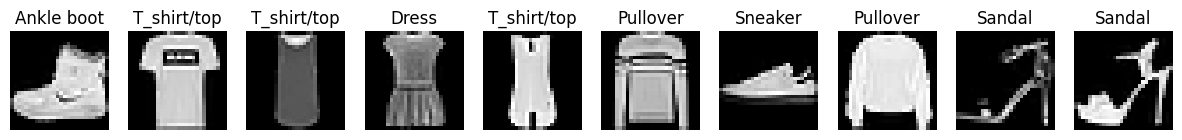

In [13]:
# Visualize some examples from the dataset
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(class_names[y.astype(int)[i]])
    ax.axis('off')
plt.show()

## Data Preprocessing


In [14]:
X = torch.tensor(X / 255.0, dtype=torch.float32, device=device)
y = torch.tensor(y.astype(int), dtype=torch.long, device=device)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print the sizes of the training and test datasets
print(f"Training dataset size: {X_train.shape}")
print(f"Test dataset size: {X_test.shape}")

Training dataset size: torch.Size([56000, 784])
Test dataset size: torch.Size([14000, 784])


# Model Overview

## Create Model


In [15]:
builder = ModelBuilder()
input_size = X_train.shape[1]
num_classes = len(torch.unique(y_train))
hidden_sizes = [512, 256, 256, 128, 64]

model = builder.build_mlp(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=num_classes,
    hidden_activation='relu',
    output_activation=None,
    initializer='Xavier'
).to(device)

learning_rate = 0.01
epochs = 100
batch_size = 128

## Define Loss Function and Optimizer


In [16]:
loss_fn = CrossEntropyLoss()
optimizer = StochGradDescent(model.get_parameters(), learning_rate=learning_rate)

## Create Trainer


In [17]:
# Create trainer
trainer = Trainer(model, loss_fn, optimizer)

## Train Model


In [18]:
# Train model
history = trainer.train(
    epochs=epochs,
    batch_size=batch_size,
    verbose=10,
    X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test
)


Epoch 1/100: train_loss=2.2095, train_accuracy=0.2106, val_loss=2.0895, val_accuracy=0.3239
Epoch 11/100: train_loss=0.7557, train_accuracy=0.7227, val_loss=0.7280, val_accuracy=0.7344
Epoch 21/100: train_loss=0.5914, train_accuracy=0.7980, val_loss=0.5675, val_accuracy=0.8098
Epoch 31/100: train_loss=0.5156, train_accuracy=0.8198, val_loss=0.4966, val_accuracy=0.8294
Epoch 41/100: train_loss=0.4755, train_accuracy=0.8321, val_loss=0.4609, val_accuracy=0.8414
Epoch 51/100: train_loss=0.4484, train_accuracy=0.8423, val_loss=0.4357, val_accuracy=0.8499
Epoch 61/100: train_loss=0.4286, train_accuracy=0.8496, val_loss=0.4188, val_accuracy=0.8570
Epoch 71/100: train_loss=0.4128, train_accuracy=0.8554, val_loss=0.4125, val_accuracy=0.8574
Epoch 81/100: train_loss=0.3992, train_accuracy=0.8595, val_loss=0.3935, val_accuracy=0.8643
Epoch 91/100: train_loss=0.3876, train_accuracy=0.8638, val_loss=0.3842, val_accuracy=0.8669
Epoch 100/100: train_loss=0.3785, train_accuracy=0.8666, val_loss=0.378

## Evaluate Model


In [19]:
# Evaluate model
metrics = trainer.evaluate(X_test, y_test)
print(f"Test Loss: {metrics['loss']:.4f}, Test Accuracy: {metrics['accuracy']:.4f}")

Test Loss: 0.3787, Test Accuracy: 0.8697


## Plot Training History


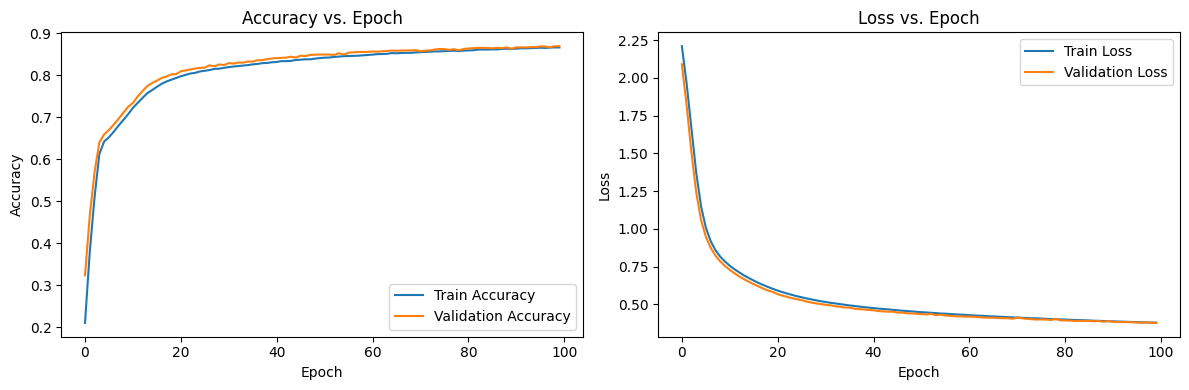

In [20]:
# Plot training history
plot_history(history)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# --- Model Definition ---
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        layers = []
        last_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(last_size, h))
            layers.append(nn.ReLU())
            last_size = h
        layers.append(nn.Linear(last_size, output_size))
        self.layers = nn.Sequential(*layers)
        # Xavier init
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    def forward(self, x):
        return self.layers(x)

model = DeepMLP(
    input_size=X_train.shape[1],
    hidden_sizes=[512, 256, 256, 128, 64],
    output_size=num_classes
).to(device)

# --- Loss Function and Optimizer ---
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# --- Training Routine ---
def train_model(model, optimizer, loss_fn, 
                X_train, y_train, X_val, y_val, 
                epochs=100, batch_size=128, verbose=10):
    train_ds = TensorDataset(X_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_ds = TensorDataset(X_val, y_val)
    val_dl = DataLoader(val_ds, batch_size=len(val_ds))

    history = {"train_loss":[], "val_loss":[], "val_acc":[]}
    for epoch in range(1, epochs+1):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            for Xv, yv in val_dl:
                Xv, yv = Xv.to(device), yv.to(device)
                val_preds = model(Xv)
                val_loss = loss_fn(val_preds, yv)
                val_acc = (val_preds.argmax(1) == yv).float().mean().item()
        train_loss = loss.item()

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss.item())
        history["val_acc"].append(val_acc)
        
        if epoch % verbose == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}: "
                  f"train loss {train_loss:.4f}, val loss {val_loss:.4f}, val acc {val_acc:.4f}")
    return history

# --- Train ---
history_pytorch = train_model(
    model, optimizer, loss_fn,
    X_train, y_train, X_test, y_test,
    epochs=100, batch_size=128, verbose=10
)

Epoch   1: train loss 0.7487, val loss 0.7287, val acc 0.7503
Epoch  10: train loss 0.2364, val loss 0.3919, val acc 0.8627
Epoch  20: train loss 0.3151, val loss 0.3519, val acc 0.8732
Epoch  30: train loss 0.2194, val loss 0.3372, val acc 0.8799
Epoch  40: train loss 0.2308, val loss 0.3086, val acc 0.8898
Epoch  50: train loss 0.2886, val loss 0.3117, val acc 0.8915
Epoch  60: train loss 0.2363, val loss 0.3910, val acc 0.8726
Epoch  70: train loss 0.2446, val loss 0.3387, val acc 0.8886
Epoch  80: train loss 0.0732, val loss 0.3714, val acc 0.8821
Epoch  90: train loss 0.1784, val loss 0.4811, val acc 0.8663
Epoch 100: train loss 0.0881, val loss 0.3688, val acc 0.8958


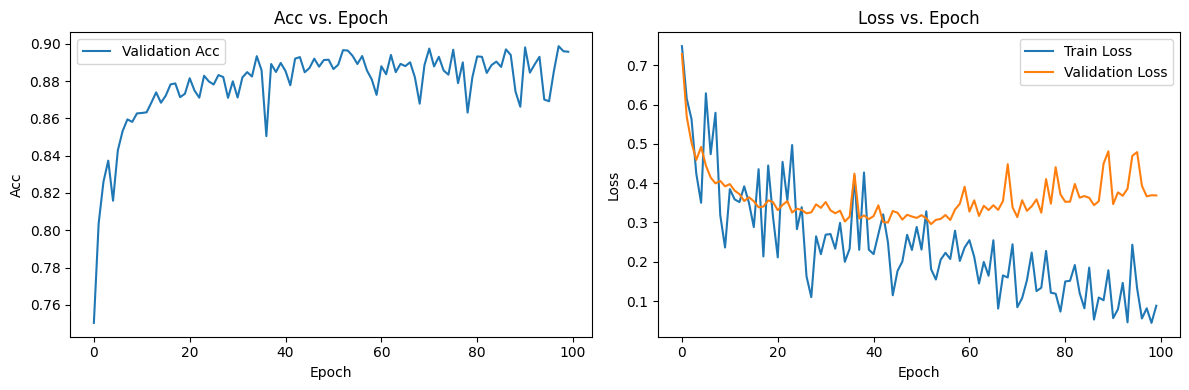

In [23]:
plot_history(history_pytorch)